In [2]:
!pip -q install yfinance statsmodels # ライブラリのインストール

In [3]:
# ライブラリの読み込み
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from statsmodels.tsa.api import VAR

In [4]:
# パラメータの設定
YEARS = 10
TICKER_SBG = "9984.T" # ソフトバンクグループ
TICKER_MKT = "^N225" # 日経平均
TICKER_FX = "JPY=X" # ドル円(USD/JPY)

In [5]:
# パラメータ設定
def get_close(ticker):
  df = yf.download(ticker, start = start, end = end,
auto_adjust = True, progress = False) # 配当・分割調整済みの終値を使う。
  series = df["Close"]
  series.name = ticker # 列名をティッカー名に変更
  return series

In [6]:
# ３系列のデータを取得
end = date.today()
start = end - timedelta(days = YEARS * 365) # 閏年を考慮して365日*YEARSで計算

px_sbg = get_close(TICKER_SBG)
px_mkt = get_close(TICKER_MKT)
px_fx = get_close(TICKER_FX)

In [7]:
# データ結合とリターン計算

# 1. データを結合してDataFrame化
df = pd.concat([px_sbg, px_mkt, px_fx], axis=1)
df.columns = ["SBG", "Nikkei", "USDJPY"]
df = df.dropna()  # 欠損値を除去

In [8]:
# 対数変換
df_log = np.log(df)

In [9]:
# 差分を取って定常化
df_diff = df_log.diff().dropna()

In [10]:
#ラグの次数選択
model = VAR(df_diff)
lag_order = model.select_order(maxlags = 3)
print(lag_order.summary() )

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -26.76     -26.75*   2.386e-12      -26.76
1     -26.78*      -26.75  2.350e-12*     -26.77*
2      -26.77      -26.72   2.358e-12      -26.76
3      -26.77      -26.70   2.355e-12      -26.75
-------------------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# AICで選ばれたラグ次数を選択
selected_lag = lag_order.selected_orders['aic']
print(f'選択されたラグ次数: {selected_lag}')

選択されたラグ次数: 1


In [12]:
# VARモデルをフィット
var_model = model.fit(selected_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     14:13:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -26.7487
Nobs:                     2435.00    HQIC:                  -26.7669
Log likelihood:           22248.0    FPE:                2.34840e-12
AIC:                     -26.7773    Det(Omega_mle):     2.33686e-12
--------------------------------------------------------------------
Results for equation SBG
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000692         0.000561            1.233           0.218
L1.SBG            0.044086         0.027196            1.621           0.105
L1.Nikkei        -0.056656         0.058405           -0.970           0.332
L

In [15]:
# 予測
forecast = var_model.forecast(df_diff.values[-selected_lag:], steps = 10)
forecast_df = pd.DataFrame(forecast, columns = df_diff.columns)
print(forecast_df)

        SBG    Nikkei    USDJPY
0  0.002914  0.000200  0.000172
1  0.000824  0.000417  0.000066
2  0.000711  0.000382  0.000099
3  0.000710  0.000386  0.000096
4  0.000710  0.000385  0.000096
5  0.000710  0.000385  0.000096
6  0.000710  0.000385  0.000096
7  0.000710  0.000385  0.000096
8  0.000710  0.000385  0.000096
9  0.000710  0.000385  0.000096


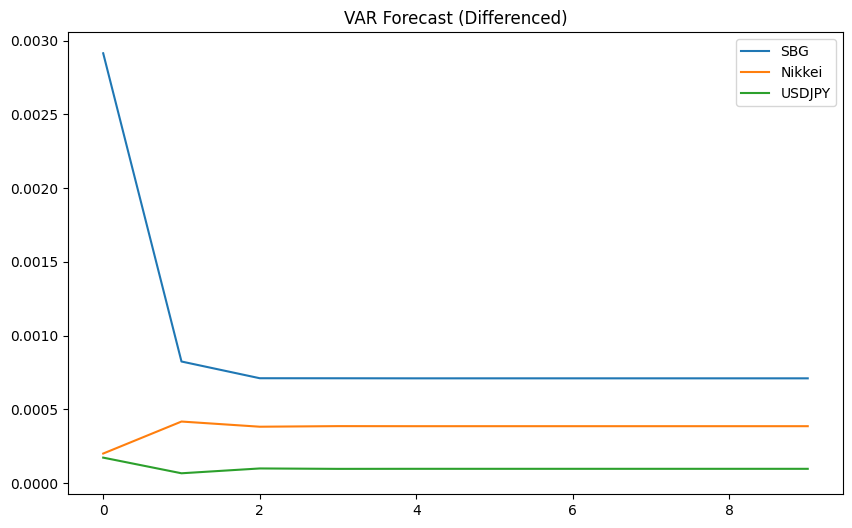

In [16]:
# 予測結果の可視化
forecast_df.plot(figsize = (10, 6))
plt.title("VAR Forecast (Differenced)")
plt.show()

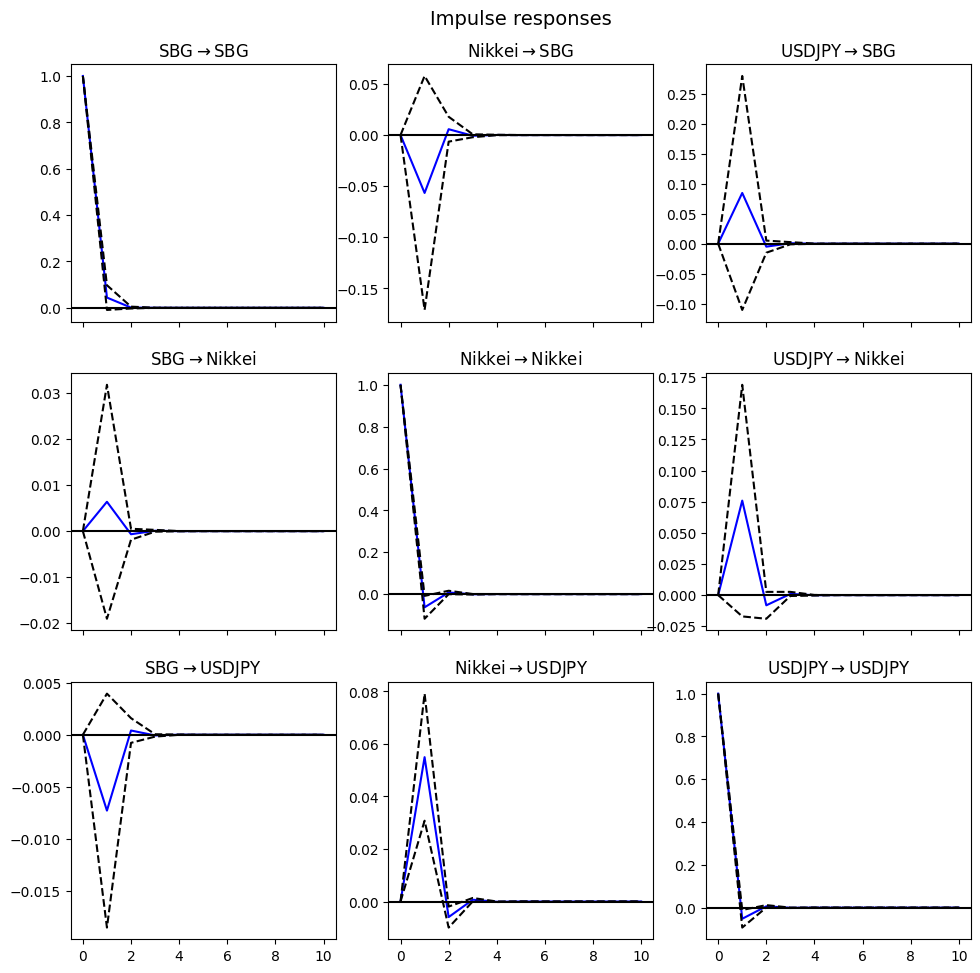

In [17]:
# インパルス応答分析
irf = var_model.irf(10)
# 結果を表示
irf.plot(orth = False)
plt.show()

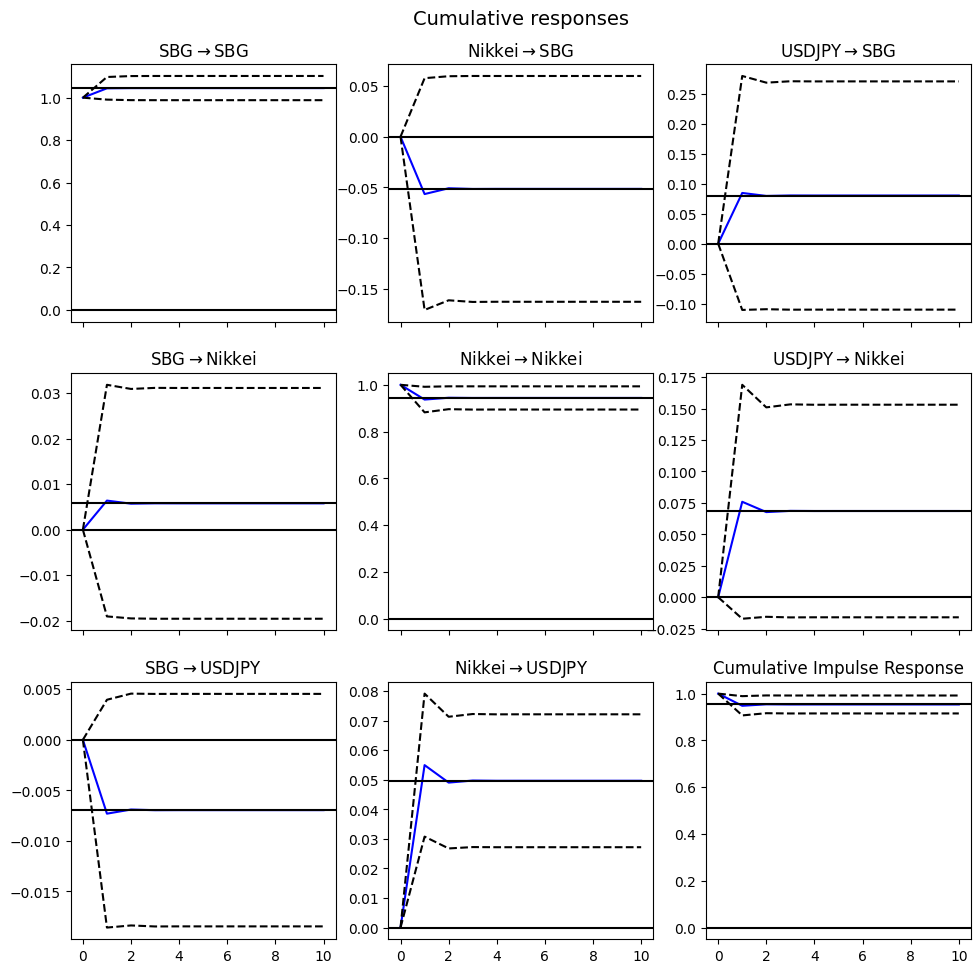

In [18]:
# 累積効果のグラフ
irf.plot_cum_effects(orth = False)
plt.title("Cumulative Impulse Response")
plt.show()